In [113]:
import pydicom
from pathlib import Path
import numpy as np
import PIL
import os
import glob
import pandas as pd
from tqdm import tqdm
import glob
import cv2
import multiprocessing as mp
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import collections
import tensorflow as tf

In [43]:
train_csv = pd.read_csv('../data/train.csv')

In [44]:
dicom_images = glob.glob('../data/train_images/*/*.dcm')

In [45]:
def fix_paths_csv(patient_id, image_id):
    return '../data/train_images/' + str(patient_id) + '/' + str(image_id) + '.dcm'

In [46]:
train_csv['updated_paths'] = train_csv.apply(lambda x: fix_paths_csv(x.patient_id, x.image_id), axis = 1)

Code to convert dicom images to pngs.

1. Crop image_array with 100 top and 100 down pixels
2. Find base cut off path with all values as 0
3. If step 2 does not work do max value search and cut off from that point
4. If step 2 and 3 does not work and get system error then flip imagearray and repeat 2 and 3.

In [6]:
train_csv.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,updated_paths
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,../data/train_images/10006/462822612.dcm
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,../data/train_images/10006/1459541791.dcm
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,../data/train_images/10006/1864590858.dcm
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,../data/train_images/10006/1874946579.dcm
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,../data/train_images/10011/220375232.dcm


In [29]:
def zeros_and_crop(img_arr, img_array):
    whole_array_zero = False
    count_zeros = np.all(img_arr == 0, axis = 0)
    cut_off_num = np.where(count_zeros == True)
    cropped_arr = img_array[:, :cut_off_num[0][0]]
    if len(cropped_arr[0]) == 0:
        raise IndexError
    return cropped_arr

def non_zero_crop(img_arr, img_array, max_value = 20):
    max_vals = np.max(img_arr, axis = 0)
    cut_off_num = np.where(max_vals < max_value)
    cropped_arr = img_array[:, :cut_off_num[0][0]]
    if len(cropped_arr[0]) == 0:
        raise SystemError
    return cropped_arr

In [32]:
def cut_pngs(img_array, direction):
    img_arr = img_array.copy()
    img_arr = img_arr[100:-100, :]
    if direction == 'L':
        try:
            cropped_arr = zeros_and_crop(img_arr, img_array)
        except IndexError:
            try:
                cropped_arr = non_zero_crop(img_arr, img_array)
            except SystemError:
                img_arr = img_arr[:, ::-1]
                img_array = img_array[:, ::-1]
                try:
                    cropped_arr = zeros_and_crop(img_arr, img_array)
                except IndexError:
                    cropped_arr = non_zero_crop(img_arr, img_array)
                cropped_arr = cropped_arr[:, ::-1]
    if direction == 'R':
        img_arr = img_arr[:, ::-1]
        img_array = img_array[:, ::-1]
        try:
            cropped_arr = zeros_and_crop(img_arr, img_array)
            cropped_arr = cropped_arr[:, ::-1]
        except IndexError:
            try:
                cropped_arr = non_zero_crop(img_arr, img_array)    
                cropped_arr = cropped_arr[:, ::-1]
            except SystemError:
                img_arr = img_arr[:, ::-1]
                img_array = img_array[:, ::-1]
                try:
                    cropped_arr = zeros_and_crop(img_arr, img_array)
                except IndexError:
                    cropped_arr = non_zero_crop(img_arr, img_array)
    return cropped_arr

def convert_dicom_to_pngs(data_iter):
    img_path, direction = data_iter[0], data_iter[1]
    save_file_path = img_path.replace('train', 'fixed').replace('images', 'pngs').replace('dcm', 'png')
    folder_path = '/'.join(save_file_path.split('/')[:-1]) + '/'
    if os.path.exists(folder_path) == False:
        os.makedirs(folder_path)
    img = pydicom.read_file(img_path)
    img_array = img.pixel_array
    if img.PhotometricInterpretation == "MONOCHROME1":
        img_array = np.amax(img_array) - img_array
    img_array = img_array - np.min(img_array)
    img_array = img_array / np.max(img_array)
    img_array = (img_array * 255).astype(np.uint8)
    return_var = ''
    try:
        cropped_arr = cut_pngs(img_array, direction)
    except:
        return_var += f'Cropping issue. {img_path}'
        return return_var
    try:
        final_img = PIL.Image.fromarray(cropped_arr)
        final_img.save(save_file_path)
        return 'File Saved'
    except:
        return_var += 'Saving issue.'
    return return_var
        # return [save_file_path, cropped_arr, direction]

In [33]:
data_paths = train_csv[['updated_paths', 'laterality']].values.tolist()

In [34]:
import multiprocessing as mp

In [35]:
with mp.Pool(30) as p:
    issues_list = p.map(convert_dicom_to_pngs, data_paths)

In [50]:
issue_paths = []
for x in issues_list:
    if x != 'File Saved':
        issue_paths.append(x.split(' ')[-1])

In [54]:
# # removing those non-use files
# issue_img_paths = []
# for x in issue_paths:   
#     updated_path = x.replace('train', 'fixed').replace('images', 'pngs').replace('dcm', 'png')
#     try:
#         os.remove(updated_path)
#     except:
#         pass

In [58]:
def convert_dicom_pngs_only(path):
    img_path = path
    updated_path = img_path.replace('train', 'fixed').replace('images', 'pngs').replace('dcm', 'png')
    img = pydicom.read_file(img_path)
    img_array = img.pixel_array
    if img.PhotometricInterpretation == "MONOCHROME1":
        img_array = np.amax(img_array) - img_array
    img_array = img_array - np.min(img_array)
    img_array = img_array / np.max(img_array)
    img_array = (img_array * 255).astype(np.uint8)
    final_img = PIL.Image.fromarray(img_array)
    final_img.save(updated_path)

In [59]:
for x in tqdm(issue_paths):
    convert_dicom_pngs_only(x)

100%|██████████| 397/397 [06:40<00:00,  1.01s/it]


In [3]:
# check any image is empty or not
png_files = glob.glob('../data/fixed_pngs/*/*.png')

In [4]:
def check_good_bads(png_path):
    if np.any(np.array(PIL.Image.open(png_path)) > 0) == True:
        return 'GOOD'
    else:
        return 'BAD'

In [5]:
with mp.Pool(30) as p:
    good_bad = p.map(check_good_bads, png_files)

In [7]:
for x in good_bad:
    if x != 'GOOD':
        print(x)

In [37]:
def resize_and_store_images(img_path, shape = (256, 256)):
    try:
        img_path_updated = img_path.replace('fixed', 'imgs').replace('pngs', '256')
        dir_path = '/'.join(img_path_updated.split('/')[:-1])
        if os.path.exists(dir_path) == False:
            os.makedirs(dir_path)
        img = PIL.Image.open(img_path)
        img = img.resize(shape)
        img.save(img_path_updated)
        return 'File Saved'
    except:
        return f'Issue: {img_path}'

In [29]:
# with mp.Pool(30) as p:
#     saver_1024 = p.map(resize_and_store_images, png_files)

In [33]:
# with mp.Pool(30) as p:
#     saver_512 = p.map(resize_and_store_images, png_files)

In [40]:
# with mp.Pool(30) as p:
#     saver_256 = p.map(resize_and_store_images, png_files)

In [114]:
def _bytes_feature(data):
    if isinstance(data, type(tf.constant(0))):
        data = data.numpy()
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [data]))
def file_name_feature(data):
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [data]))
def label_feature(data):
    return tf.train.Feature(int64_list = tf.train.Int64List(value = [data]))

In [117]:
def serialize_example(img, label, file_name):
    feature = {
        'image': _bytes_feature(img),
        'label': label_feature(label),
        'file_name': file_name_feature(file_name)
    }
    example_proto = tf.train.Example(features = tf.train.Features(feature = feature))
    return example_proto.SerializeToString()

In [139]:
def write_tfrec(data_list, tfrec_path):
    with tf.io.TFRecordWriter(tfrec_path) as writer:
        for idx in tqdm(range(len(data_list))):
            path, lab, file_name = data_list[idx][0], data_list[idx][1], data_list[idx][2]
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tostring()
            label = lab
            example = serialize_example(
                img, label, bytes(file_name, 'utf-8')
            )
            writer.write(example)

In [57]:
train_csv.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,updated_paths
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,../data/train_images/10006/462822612.dcm
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,../data/train_images/10006/1459541791.dcm
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,../data/train_images/10006/1864590858.dcm
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,../data/train_images/10006/1874946579.dcm
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,../data/train_images/10011/220375232.dcm


In [69]:
def split_datasets(csv_file):
    train, test = train_test_split(csv_file, test_size = 0.01)
    train, val = train_test_split(train, test_size = 0.01)
    return train, val, test

In [70]:
train, val, test = split_datasets(train_csv)

In [94]:
train_collec = collections.Counter(train['cancer'].values.tolist())
train_key = list(train_collec.keys())
train_vals = list(train_collec.values())
print(f'Train label 0: {train_vals[0] / sum(train_vals)}')
print(f'Train label 0: {train_vals[1] / sum(train_vals)}')
print(f'0: {train_vals[0]}, 1: {train_vals[1]}')

Train label 0: 0.9787749925395405
Train label 0: 0.021225007460459563
0: 52478, 1: 1138


<BarContainer object of 2 artists>

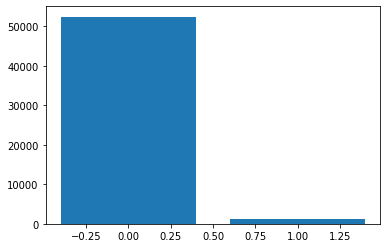

In [95]:
plt.bar(train_key, train_vals)

In [93]:
val_collec = collections.Counter(val['cancer'].values.tolist())
val_key = list(val_collec.keys())
val_vals = list(val_collec.values())
print(f'Train label 0: {val_vals[0] / sum(val_vals)}')
print(f'Train label 0: {val_vals[1] / sum(val_vals)}')
print(f'0: {val_vals[0]}, 1: {val_vals[1]}')

Train label 0: 0.9833948339483395
Train label 0: 0.016605166051660517
0: 533, 1: 9


<BarContainer object of 2 artists>

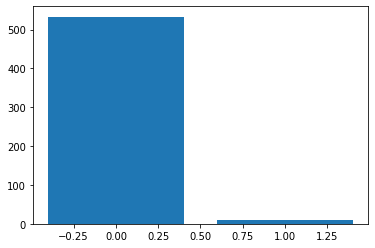

In [101]:
plt.bar(val_key, val_vals)

In [100]:
test_collec = collections.Counter(test['cancer'].values.tolist())
test_key = list(test_collec.keys())
test_vals = list(test_collec.values())
print(f'Test label 0: {test_vals[1] / sum(test_vals)}')
print(f'Test label 1: {test_vals[0] / sum(test_vals)}')
print(f'0: {test_vals[1]}, 1: {test_vals[0]}')

Test label 0: 0.9799270072992701
Test label 1: 0.020072992700729927
0: 537, 1: 11


<BarContainer object of 2 artists>

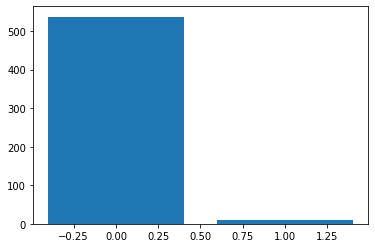

In [102]:
plt.bar(test_key, test_vals)

In [150]:
def get_final_data(csv_file):
    imgs = [x.replace('train', 'imgs').replace('images', '1024').replace('dcm', 'png') for x in csv_file['updated_paths'].values.tolist()]
    labels = train_csv['cancer'].values.tolist()
    file_names = ['/'.join(x.split('/')[-2:]) for x in imgs]
    final_list = [[imgs[x], labels[x], file_names[x]] for x in range(len(imgs))]
    return final_list

In [141]:
train_256 = get_final_data(train) 
val_256 = get_final_data(val)
test_256 = get_final_data(test)

In [142]:
write_tfrec(train_256, '../data/train_256.tfrec')

  0%|          | 0/53616 [00:00<?, ?it/s]<ipython-input-139-8d6ffe62272f>:6: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tostring()
100%|██████████| 53616/53616 [00:57<00:00, 927.78it/s]


In [144]:
write_tfrec(val_256, '../data/val_256.tfrec')

  0%|          | 0/542 [00:00<?, ?it/s]<ipython-input-139-8d6ffe62272f>:6: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tostring()
100%|██████████| 542/542 [00:00<00:00, 923.42it/s]


In [143]:
write_tfrec(test_256, '../data/test_256.tfrec')

  0%|          | 0/548 [00:00<?, ?it/s]<ipython-input-139-8d6ffe62272f>:6: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tostring()
100%|██████████| 548/548 [00:00<00:00, 940.31it/s]


In [146]:
train_512 = get_final_data(train) 
val_512 = get_final_data(val)
test_512 = get_final_data(test)

In [147]:
write_tfrec(train_512, '../data/train_512.tfrec')

  0%|          | 0/53616 [00:00<?, ?it/s]<ipython-input-139-8d6ffe62272f>:6: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tostring()
100%|██████████| 53616/53616 [03:37<00:00, 246.39it/s]


In [148]:
write_tfrec(val_512, '../data/val_512.tfrec')

  0%|          | 0/542 [00:00<?, ?it/s]<ipython-input-139-8d6ffe62272f>:6: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tostring()
100%|██████████| 542/542 [00:02<00:00, 253.95it/s]


In [149]:
write_tfrec(test_512, '../data/test_512.tfrec')

  0%|          | 0/548 [00:00<?, ?it/s]<ipython-input-139-8d6ffe62272f>:6: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tostring()
100%|██████████| 548/548 [00:02<00:00, 253.65it/s]


In [151]:
train_1024 = get_final_data(train) 
val_1024 = get_final_data(val)
test_1024 = get_final_data(test)

In [152]:
write_tfrec(train_1024, '../data/train_1024.tfrec')

  0%|          | 0/53616 [00:00<?, ?it/s]<ipython-input-139-8d6ffe62272f>:6: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tostring()
100%|██████████| 53616/53616 [12:12<00:00, 73.20it/s]


In [153]:
write_tfrec(val_1024, '../data/val_1024.tfrec')

  0%|          | 0/542 [00:00<?, ?it/s]<ipython-input-139-8d6ffe62272f>:6: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tostring()
100%|██████████| 542/542 [00:07<00:00, 73.92it/s]


In [154]:
write_tfrec(test_1024, '../data/test_1024.tfrec')

  0%|          | 0/548 [00:00<?, ?it/s]<ipython-input-139-8d6ffe62272f>:6: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tostring()
100%|██████████| 548/548 [00:07<00:00, 72.83it/s]
